# Chest X-Ray Classification - COMBINED DATASETS
## COVID-19, Pneumonia, and Normal Detection

**This notebook combines TWO datasets:**
- COVID-19 Radiography Database: 21,165 images
- Pneumonia Dataset: 5,856 images
- **TOTAL: ~27,000 images**

**Classes:**
1. Normal
2. Pneumonia
3. COVID-19
4. Lung Opacity

**Estimated GPU Time:** 8-10 hours (larger dataset)

In [ ]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.17 GB


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set project directory
import os
project_dir = '/content/drive/MyDrive/medical-ai-project/chest-xray-classification'
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)
print(f"Working directory: {os.getcwd()}")

Mounted at /content/drive
Working directory: /content/drive/MyDrive/medical-ai-project/chest-xray-classification


In [ ]:
# Install dependencies
!pip install -q torch torchvision
!pip install -q scikit-learn matplotlib seaborn
!pip install -q pillow pandas numpy
!pip install -q grad-cam
print("✓ All dependencies installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✓ All dependencies installed!


In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Configuration

In [ ]:
# Configuration
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 30  # More epochs for larger dataset
LEARNING_RATE = 0.0001
NUM_CLASSES = 4
CLASS_NAMES = ['Normal', 'Pneumonia', 'COVID', 'Lung_Opacity']

print(f"Configuration:")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Classes: {CLASS_NAMES}")

Configuration:
  Image size: 224x224
  Batch size: 32
  Epochs: 30
  Learning rate: 0.0001
  Classes: ['Normal', 'Pneumonia', 'COVID', 'Lung_Opacity']


## Dataset Classes

In [ ]:
# Custom Dataset Class
class ChestXrayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            # Return a black image and label if error
            return torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE), self.labels[idx]

print("✓ Dataset class defined")

✓ Dataset class defined


## Data Transforms

In [ ]:
# Data transforms with strong augmentation for combined dataset
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✓ Data transforms configured")

✓ Data transforms configured


## Load COMBINED Datasets

This cell combines:
1. COVID-19 Radiography Database (21,165 images)
2. Pneumonia Dataset (5,856 images)

Total: ~27,000 images

In [ ]:
# ============================================================
# COMBINED CHEST X-RAY DATASET LOADER
# ============================================================

print("="*70)
print("LOADING COMBINED CHEST X-RAY DATASETS")
print("="*70)

base_data_dir = Path('./data')
image_paths = []
labels = []

class_to_idx = {name: idx for idx, name in enumerate(CLASS_NAMES)}

# ============================================================
# 1. Load COVID-19 Radiography Dataset
# ============================================================
print("\n📁 Loading COVID-19 Radiography Dataset...")
covid_dataset_path = base_data_dir / 'COVID-19_Radiography_Dataset'

covid_class_mapping = {
    'Normal': 'Normal',
    'Viral Pneumonia': 'Pneumonia',
    'COVID': 'COVID',
    'Lung_Opacity': 'Lung_Opacity'
}

for covid_class, combined_class in covid_class_mapping.items():
    class_path = covid_dataset_path / covid_class / 'images'
    if class_path.exists():
        class_images = list(class_path.glob('*.png')) + list(class_path.glob('*.jpg'))
        image_paths.extend(class_images)
        labels.extend([class_to_idx[combined_class]] * len(class_images))
        print(f"  {covid_class:20s} → {combined_class:15s}: {len(class_images):,} images")

# ============================================================
# 2. Load Pneumonia Dataset
# ============================================================
print("\n📁 Loading Pneumonia Dataset...")
pneumonia_dataset_path = base_data_dir / 'pneumonia_dataset' / 'chest_xray' / 'chest_xray'

pneumonia_class_mapping = {
    'NORMAL': 'Normal',
    'PNEUMONIA': 'Pneumonia'
}

for split in ['train', 'test', 'val']:
    split_path = pneumonia_dataset_path / split
    if split_path.exists():
        for pneumonia_class, combined_class in pneumonia_class_mapping.items():
            class_path = split_path / pneumonia_class
            if class_path.exists():
                class_images = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
                image_paths.extend(class_images)
                labels.extend([class_to_idx[combined_class]] * len(class_images))
                print(f"  {split}/{pneumonia_class:10s} → {combined_class:15s}: {len(class_images):,} images")

# ============================================================
# Summary
# ============================================================
print("\n" + "="*70)
print("COMBINED DATASET SUMMARY")
print("="*70)
print(f"Total images loaded: {len(image_paths):,}")

class_counts = np.bincount(labels)
for i, class_name in enumerate(CLASS_NAMES):
    print(f"  {class_name:20s}: {class_counts[i]:,} images ({class_counts[i]/len(labels)*100:.1f}%)")

# ============================================================
# Split into train and validation sets
# ============================================================
print("\n" + "="*70)
print("SPLITTING DATA")
print("="*70)

X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

# Create datasets and loaders
train_dataset = ChestXrayDataset(X_train, y_train, transform=train_transform)
val_dataset = ChestXrayDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\n✓ Combined dataset loaded successfully!")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print("="*70)

LOADING COMBINED CHEST X-RAY DATASETS

📁 Loading COVID-19 Radiography Dataset...
  Normal               → Normal         : 10,192 images
  Viral Pneumonia      → Pneumonia      : 1,345 images
  COVID                → COVID          : 3,616 images
  Lung_Opacity         → Lung_Opacity   : 6,012 images

📁 Loading Pneumonia Dataset...
  train/NORMAL     → Normal         : 1,341 images
  train/PNEUMONIA  → Pneumonia      : 2,133 images
  test/NORMAL     → Normal         : 234 images
  test/PNEUMONIA  → Pneumonia      : 390 images

COMBINED DATASET SUMMARY
Total images loaded: 25,263
  Normal              : 11,767 images (46.6%)
  Pneumonia           : 3,868 images (15.3%)
  COVID               : 3,616 images (14.3%)
  Lung_Opacity        : 6,012 images (23.8%)

SPLITTING DATA
Training samples: 20,210
Validation samples: 5,053

✓ Combined dataset loaded successfully!
  Training batches: 632
  Validation batches: 158


## Model Architecture

In [ ]:
# Load pre-trained ResNet50
print("Loading ResNet50 with ImageNet weights...")
model = models.resnet50(pretrained=True)

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)
print(f"✓ Model loaded on {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Loading ResNet50 with ImageNet weights...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 243MB/s]


✓ Model loaded on cuda
Total parameters: 24,560,196
Trainable parameters: 1,052,164


## Training Setup with Class Balancing

In [ ]:
# Calculate class weights for imbalanced dataset
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = torch.FloatTensor(class_weights / class_weights.sum()).to(device)

print("Class distribution in training set:")
for i, name in enumerate(CLASS_NAMES):
    print(f"  {name:20s}: {class_counts[i]:,} samples (weight: {class_weights[i]:.4f})")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print("\n✓ Training setup complete with class balancing")

Class distribution in training set:
  Normal              : 9,413 samples (weight: 0.1081)
  Pneumonia           : 3,094 samples (weight: 0.3288)
  COVID               : 2,893 samples (weight: 0.3516)
  Lung_Opacity        : 4,810 samples (weight: 0.2115)

✓ Training setup complete with class balancing


## Training Functions

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        pbar.set_postfix({'loss': loss.item()})

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    return epoch_loss, epoch_acc.item()


def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)

    return epoch_loss, epoch_acc.item()

print("✓ Training functions defined")

✓ Training functions defined


## Training Loop

**This will take 8-10 hours on a T4 GPU**

The model will save automatically whenever validation accuracy improves.

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_acc = 0.0
best_model_path = './models/best_chest_xray_COMBINED_model.pth'
os.makedirs('./models', exist_ok=True)

print("="*70)
print(f"STARTING TRAINING - {NUM_EPOCHS} EPOCHS")
print("="*70)
print(f"Training on {len(train_loader.dataset):,} images")
print(f"Validating on {len(val_loader.dataset):,} images")
print(f"Model will save to: {best_model_path}")
print("="*70)

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f'\n📊 Epoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 70)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    scheduler.step(val_loss)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'✓ Best model saved with accuracy: {best_acc:.4f}')

print(f"\n🎉 Training complete! Best validation accuracy: {best_acc:.4f}")
print("="*70)

STARTING TRAINING - 30 EPOCHS
Training on 20,210 images
Validating on 5,053 images
Model will save to: ./models/best_chest_xray_COMBINED_model.pth

📊 Epoch 1/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [33:07<00:00, 12.58s/it]


Train Loss: 0.8251 | Train Acc: 0.6360
Val Loss: 0.6096 | Val Acc: 0.7443
✓ Best model saved with accuracy: 0.7443

📊 Epoch 2/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.08it/s]


Train Loss: 0.7010 | Train Acc: 0.6972
Val Loss: 0.5972 | Val Acc: 0.7611
✓ Best model saved with accuracy: 0.7611

📊 Epoch 3/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.16it/s]


Train Loss: 0.6829 | Train Acc: 0.7040
Val Loss: 0.5537 | Val Acc: 0.7904
✓ Best model saved with accuracy: 0.7904

📊 Epoch 4/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  6.97it/s]


Train Loss: 0.6628 | Train Acc: 0.7162
Val Loss: 0.5592 | Val Acc: 0.7906
✓ Best model saved with accuracy: 0.7906

📊 Epoch 5/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:21<00:00,  7.20it/s]


Train Loss: 0.6403 | Train Acc: 0.7276
Val Loss: 0.5533 | Val Acc: 0.7906

📊 Epoch 6/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.07it/s]


Train Loss: 0.6272 | Train Acc: 0.7332
Val Loss: 0.5420 | Val Acc: 0.8110
✓ Best model saved with accuracy: 0.8110

📊 Epoch 7/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.10it/s]


Train Loss: 0.6171 | Train Acc: 0.7387
Val Loss: 0.5230 | Val Acc: 0.8122
✓ Best model saved with accuracy: 0.8122

📊 Epoch 8/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.06it/s]


Train Loss: 0.6178 | Train Acc: 0.7407
Val Loss: 0.5193 | Val Acc: 0.8063

📊 Epoch 9/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.16it/s]


Train Loss: 0.6092 | Train Acc: 0.7436
Val Loss: 0.5298 | Val Acc: 0.8132
✓ Best model saved with accuracy: 0.8132

📊 Epoch 10/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.05it/s]


Train Loss: 0.6068 | Train Acc: 0.7426
Val Loss: 0.5212 | Val Acc: 0.8251
✓ Best model saved with accuracy: 0.8251

📊 Epoch 11/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  6.90it/s]


Train Loss: 0.6021 | Train Acc: 0.7450
Val Loss: 0.5180 | Val Acc: 0.8027

📊 Epoch 12/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  6.95it/s]


Train Loss: 0.6037 | Train Acc: 0.7427
Val Loss: 0.4966 | Val Acc: 0.8165

📊 Epoch 13/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  6.93it/s]


Train Loss: 0.5946 | Train Acc: 0.7445
Val Loss: 0.5153 | Val Acc: 0.8148

📊 Epoch 14/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.05it/s]


Train Loss: 0.5971 | Train Acc: 0.7478
Val Loss: 0.5264 | Val Acc: 0.8163

📊 Epoch 15/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.00it/s]


Train Loss: 0.5899 | Train Acc: 0.7467
Val Loss: 0.5145 | Val Acc: 0.8132

📊 Epoch 16/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.01it/s]


Train Loss: 0.5825 | Train Acc: 0.7515
Val Loss: 0.5270 | Val Acc: 0.8037

📊 Epoch 17/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.01it/s]


Train Loss: 0.5707 | Train Acc: 0.7574
Val Loss: 0.4968 | Val Acc: 0.8207

📊 Epoch 18/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  6.92it/s]


Train Loss: 0.5720 | Train Acc: 0.7553
Val Loss: 0.4995 | Val Acc: 0.8193

📊 Epoch 19/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  6.96it/s]


Train Loss: 0.5713 | Train Acc: 0.7575
Val Loss: 0.5144 | Val Acc: 0.8217

📊 Epoch 20/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.15it/s]


Train Loss: 0.5756 | Train Acc: 0.7559
Val Loss: 0.4802 | Val Acc: 0.8235

📊 Epoch 21/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  6.95it/s]


Train Loss: 0.5657 | Train Acc: 0.7611
Val Loss: 0.5004 | Val Acc: 0.8167

📊 Epoch 22/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.00it/s]


Train Loss: 0.5722 | Train Acc: 0.7549
Val Loss: 0.5110 | Val Acc: 0.8247

📊 Epoch 23/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  6.99it/s]


Train Loss: 0.5721 | Train Acc: 0.7569
Val Loss: 0.4864 | Val Acc: 0.8258
✓ Best model saved with accuracy: 0.8258

📊 Epoch 24/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.02it/s]


Train Loss: 0.5606 | Train Acc: 0.7618
Val Loss: 0.4761 | Val Acc: 0.8260
✓ Best model saved with accuracy: 0.8260

📊 Epoch 25/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  6.93it/s]


Train Loss: 0.5682 | Train Acc: 0.7580
Val Loss: 0.4937 | Val Acc: 0.8193

📊 Epoch 26/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.01it/s]


Train Loss: 0.5651 | Train Acc: 0.7597
Val Loss: 0.4922 | Val Acc: 0.8215

📊 Epoch 27/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.12it/s]


Train Loss: 0.5660 | Train Acc: 0.7635
Val Loss: 0.4958 | Val Acc: 0.8227

📊 Epoch 28/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.03it/s]


Train Loss: 0.5549 | Train Acc: 0.7622
Val Loss: 0.4883 | Val Acc: 0.8253

📊 Epoch 29/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  6.99it/s]


Train Loss: 0.5578 | Train Acc: 0.7628
Val Loss: 0.4946 | Val Acc: 0.8207

📊 Epoch 30/30
----------------------------------------------------------------------


Validation: 100%|██████████| 158/158 [00:22<00:00,  7.01it/s]


Train Loss: 0.5491 | Train Acc: 0.7664
Val Loss: 0.4866 | Val Acc: 0.8270
✓ Best model saved with accuracy: 0.8270

🎉 Training complete! Best validation accuracy: 0.8270


## Visualization - Training History

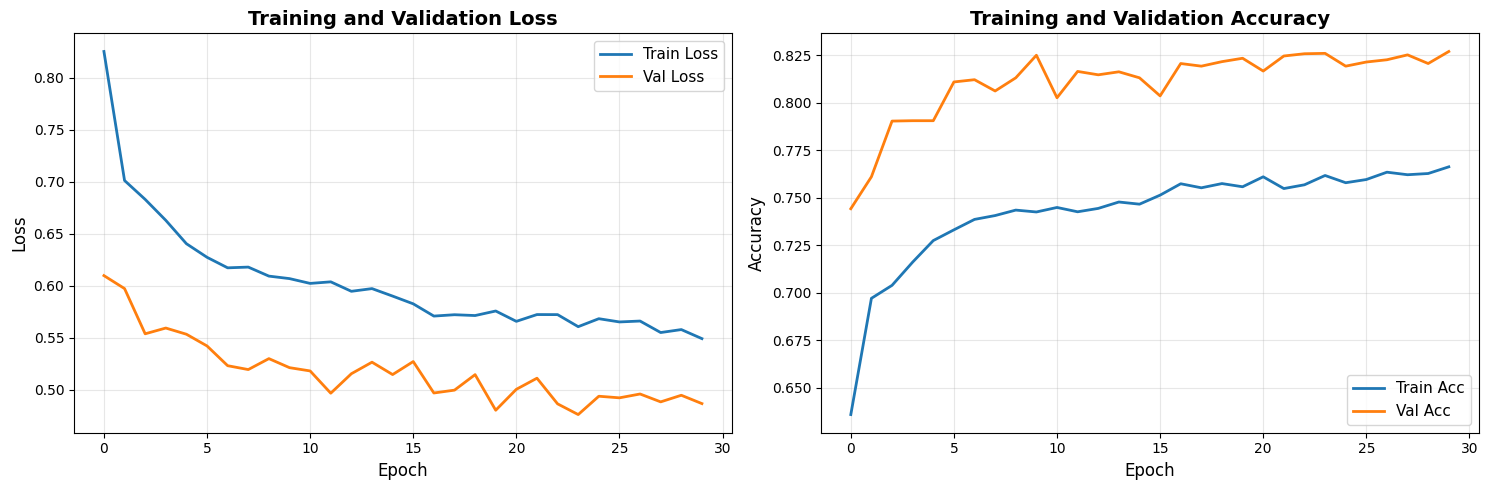

✓ Training curves saved to training_history_COMBINED.png


In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Train Acc', linewidth=2)
ax2.plot(history['val_acc'], label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./training_history_COMBINED.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved to training_history_COMBINED.png")

## Evaluation - Confusion Matrix & Classification Report

Evaluating: 100%|██████████| 158/158 [00:23<00:00,  6.87it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal     0.8925    0.8220    0.8558      2354
   Pneumonia     0.9038    0.9341    0.9187       774
       COVID     0.7923    0.5961    0.6803       723
Lung_Opacity     0.7073    0.9068    0.7948      1202

    accuracy                         0.8270      5053
   macro avg     0.8240    0.8148    0.8124      5053
weighted avg     0.8358    0.8270    0.8258      5053



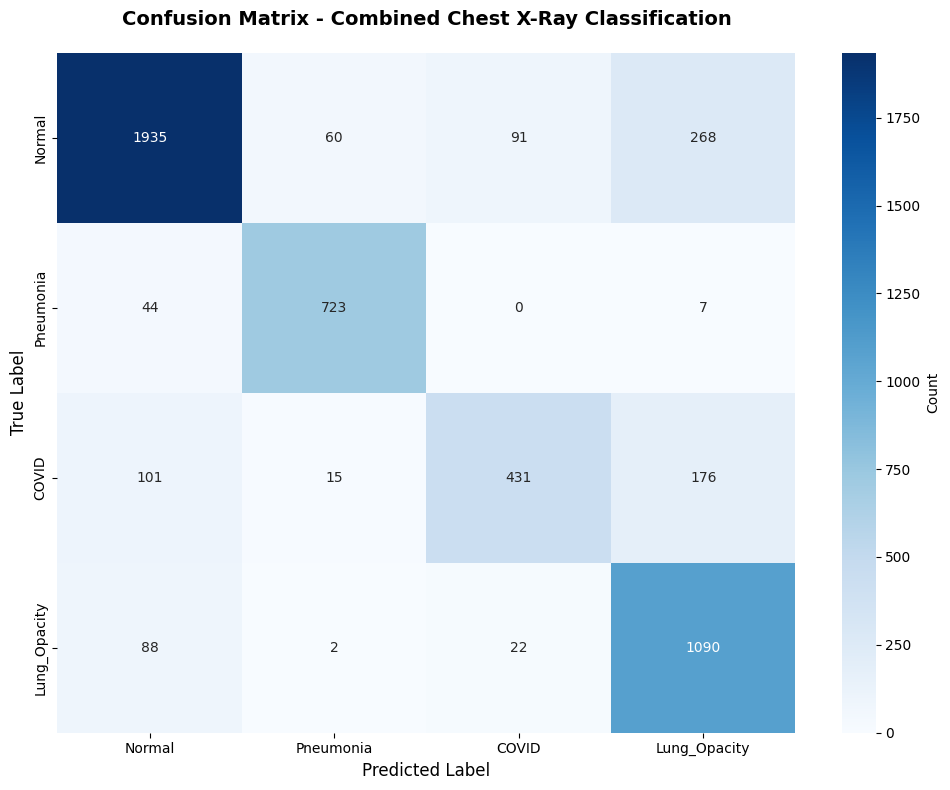


✓ Evaluation complete!
  Confusion matrix saved to: confusion_matrix_COMBINED.png
  Best model saved to: ./models/best_chest_xray_COMBINED_model.pth


In [ ]:
# Load best model for evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Evaluate model
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc='Evaluating'):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Combined Chest X-Ray Classification',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('./confusion_matrix_COMBINED.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Evaluation complete!")
print(f"  Confusion matrix saved to: confusion_matrix_COMBINED.png")
print(f"  Best model saved to: {best_model_path}")

## Per-Class Accuracy

In [ ]:
# Calculate per-class accuracy
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("="*70)
print("PER-CLASS ACCURACY")
print("="*70)
for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name:20s}: {per_class_acc[i]:.2%} ({cm[i,i]}/{cm[i].sum()})")
print(f"\nOverall Accuracy: {(y_true == y_pred).mean():.2%}")
print("="*70)

PER-CLASS ACCURACY
Normal              : 82.20% (1935/2354)
Pneumonia           : 93.41% (723/774)
COVID               : 59.61% (431/723)
Lung_Opacity        : 90.68% (1090/1202)

Overall Accuracy: 82.70%


## Save Final Summary

In [ ]:
# Save training summary
summary = {
    'dataset': 'Combined (COVID-19 Radiography + Pneumonia)',
    'total_images': len(image_paths),
    'train_images': len(X_train),
    'val_images': len(X_val),
    'classes': CLASS_NAMES,
    'num_epochs': NUM_EPOCHS,
    'best_val_acc': best_acc,
    'final_train_loss': history['train_loss'][-1],
    'final_val_loss': history['val_loss'][-1],
    'per_class_accuracy': {CLASS_NAMES[i]: float(per_class_acc[i]) for i in range(len(CLASS_NAMES))}
}

import json
with open('./training_summary_COMBINED.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✓ Training summary saved to training_summary_COMBINED.json")
print("\n🎉 All done! Your model is trained and saved.")

✓ Training summary saved to training_summary_COMBINED.json

🎉 All done! Your model is trained and saved.
